In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import random
import cv2 as cv

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, auc, roc_curve
from sklearn.metrics import log_loss

TRAINING_DATA_FOLDER = '/content/drive/My Drive/DFDC/Training_Images'
TESTING_DATA_FOLDER = '/content/drive/My Drive/DFDC/Testing_Images'
REAL_FOLDER = 'REAL'
FAKE_FOLDER = 'FAKE'

train_list_real = list(os.listdir(os.path.join(TRAINING_DATA_FOLDER, REAL_FOLDER)))
train_list_fake = list(os.listdir(os.path.join(TRAINING_DATA_FOLDER, FAKE_FOLDER)))


In [16]:
def show_train_img(Folder):
    
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(24, 10))
    
    ten_random_samples = pd.Series(os.listdir(os.path.join(TRAINING_DATA_FOLDER, Folder))).sample(10).values
    
    for idx, image in enumerate(ten_random_samples):
        final_path = os.path.join(TRAINING_DATA_FOLDER, Folder, image)
        img = cv.imread(final_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        axes.ravel()[idx].imshow(img)
        axes.ravel()[idx].axis('off')
        axes.ravel()[idx].set_title("Original")
    plt.tight_layout()


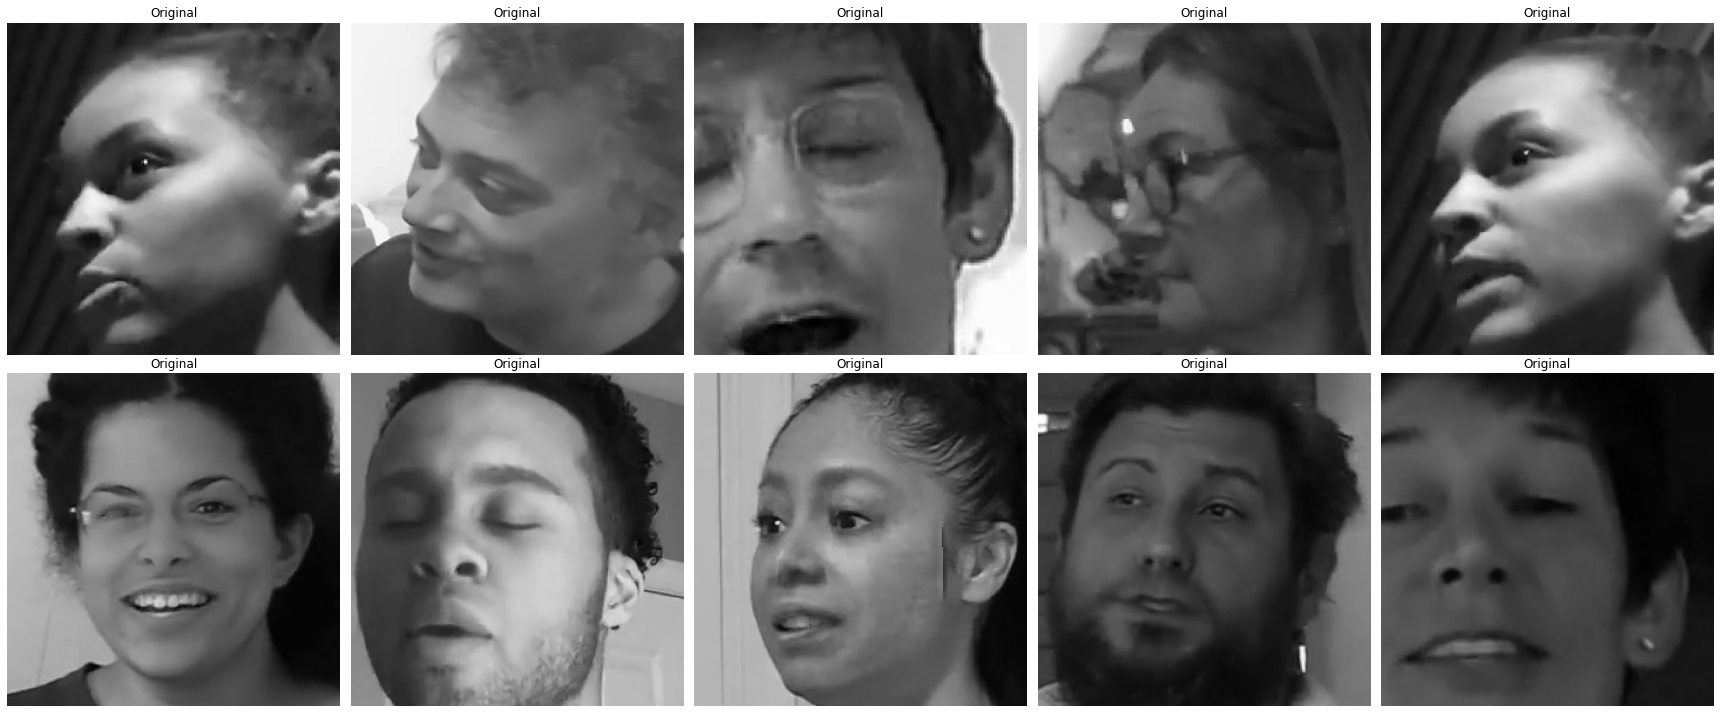

In [17]:
show_train_img(FAKE_FOLDER)

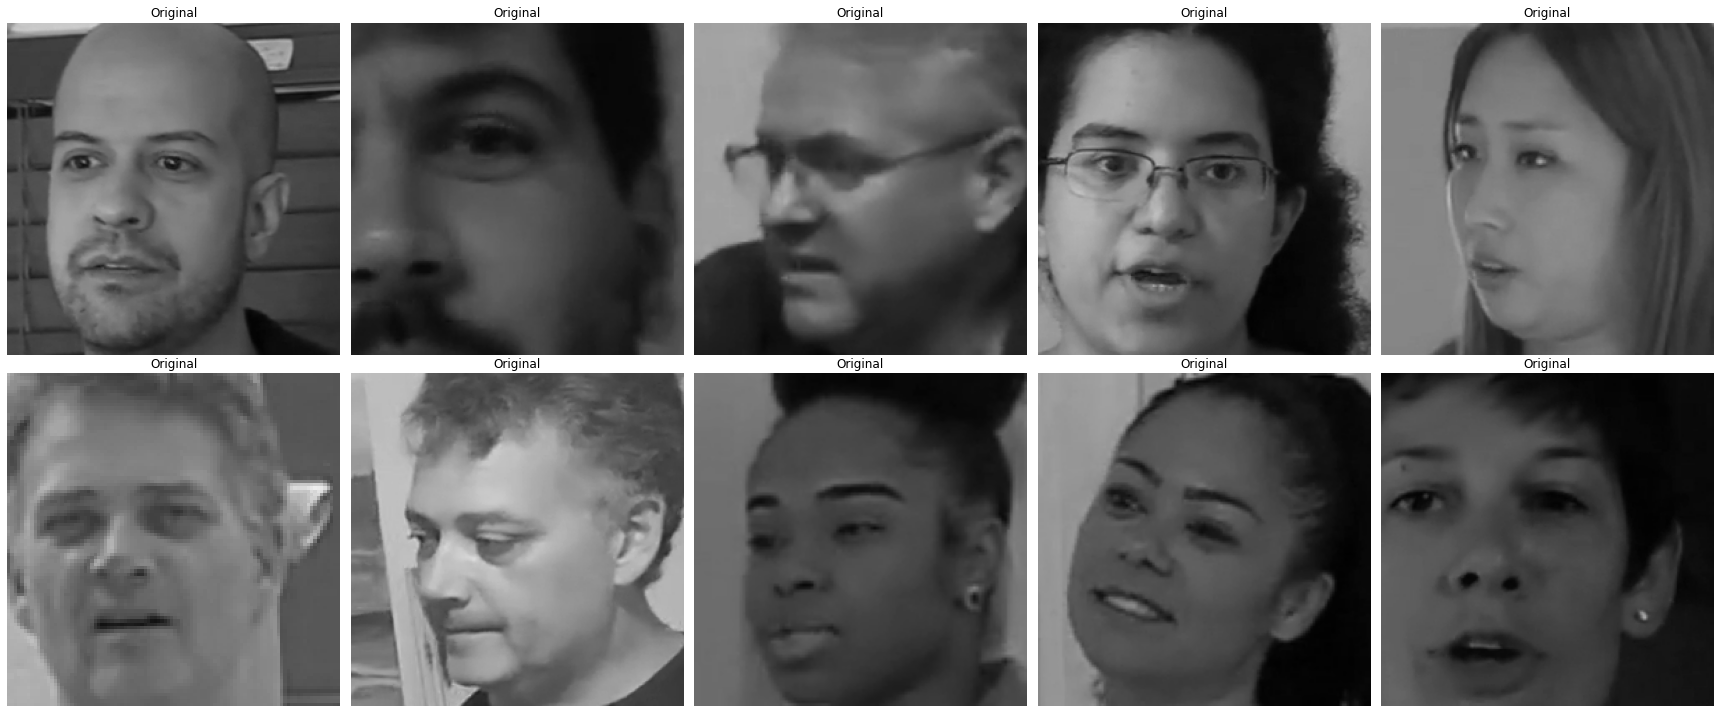

In [18]:
show_train_img(REAL_FOLDER)

In [19]:
import tensorflow as tf 
import tensorflow.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, UpSampling2D, Activation, Input
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Flatten, BatchNormalization, GaussianNoise
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model


In [20]:
#Image batch generator
random.seed(30)
batch_size = 32

train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2,brightness_range=[0.5,1.5])
test_gen = ImageDataGenerator(rescale=1./255)
train_batches = train_gen.flow_from_directory(TRAINING_DATA_FOLDER,
                                              shuffle=True,
                                              subset="training",
                                              target_size=(128,128), 
                                              batch_size=batch_size,
                                              color_mode="grayscale", 
                                              class_mode='binary')

validation_batches = train_gen.flow_from_directory(TRAINING_DATA_FOLDER,
                                              shuffle=True,
                                              subset="validation",
                                              target_size=(128,128), 
                                              batch_size=batch_size,
                                              color_mode="grayscale", 
                                              class_mode='binary')

testing_batches = test_gen.flow_from_directory(TESTING_DATA_FOLDER,
                                              shuffle=True,
                                              target_size=(128,128), 
                                              batch_size=batch_size,
                                              color_mode="grayscale", 
                                              class_mode='binary')

Found 1747 images belonging to 2 classes.
Found 436 images belonging to 2 classes.
Found 63 images belonging to 2 classes.


In [21]:
def generate_data(batches):
  while True:
    x , y = batches.next()
    yield x, [x,y]

In [22]:
# Build the autoencoder classifier

encoder_input = tf.keras.Input(shape=(128,128,1))
encoder_hidden = Conv2D(64, kernel_size=3, padding='same', activation='relu', name="encov64")(encoder_input)
encoder_hidden = GaussianNoise(0.1)(encoder_hidden)
encoder_hidden = MaxPool2D((2,2), padding='same')(encoder_hidden)
encoder_hidden = Dropout(0.2)(encoder_hidden)
encoder_hidden = Conv2D(32, kernel_size=3, padding='same', activation='relu', name="encov32")(encoder_hidden)
encoder_hidden = MaxPool2D((2,2), padding='same')(encoder_hidden)
encoder_output = Dropout(0.2)(encoder_hidden)


decoder_hidden = Conv2D(32, kernel_size=3, padding='same', activation='relu', name="decov32")(encoder_output)
decoder_hidden = UpSampling2D((2,2))(decoder_hidden)
decoder_hidden = Dropout(0.2)(decoder_hidden)
decoder_hidden = Conv2D(64, kernel_size=3, padding='same', activation='relu', name="decov64")(decoder_hidden)
decoder_hidden = UpSampling2D((2,2))(decoder_hidden)
decoder_hidden = Dropout(0.2)(decoder_hidden)
decoder_output = Conv2D(64, kernel_size=3, padding='same', activation='relu', name="decoder")(decoder_hidden)

classifier = BatchNormalization()(encoder_output)
classifier = Flatten()(encoder_output)
classifier = Dense(8, kernel_initializer='glorot_uniform', bias_initializer='zeros', activation='sigmoid')(classifier)
classifier = Dense(1, activation='sigmoid', name="classifier")(classifier)

ae = Model(encoder_input, [decoder_output, classifier])
ae.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
encov64 (Conv2D)                (None, 128, 128, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 128, 128, 64) 0           encov64[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 64, 64, 64)   0           gaussian_noise_1[0][0]           
_______________________________________________________________________________________

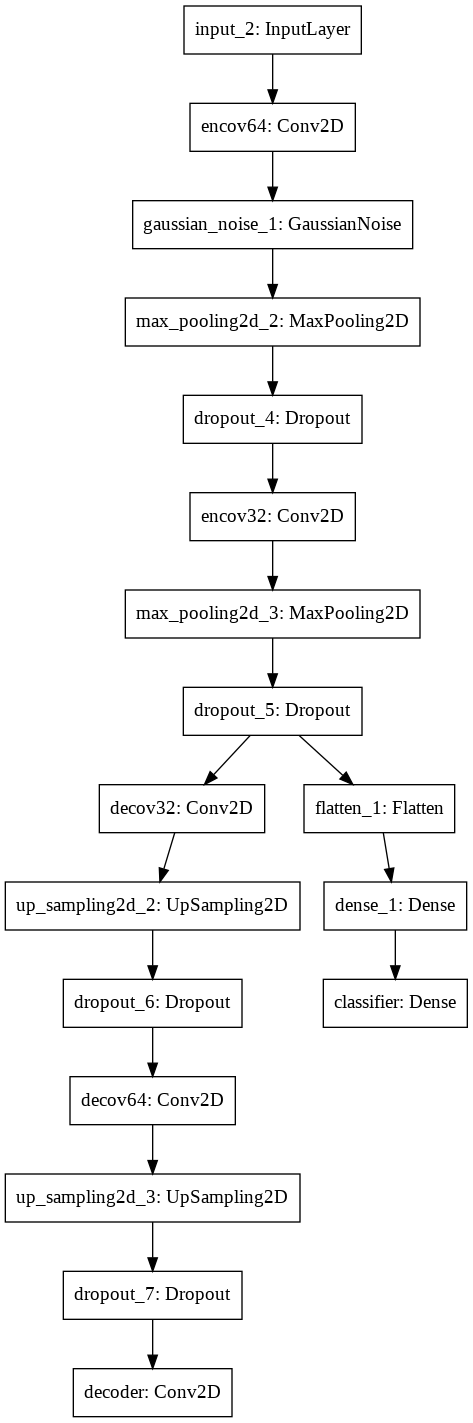

In [23]:
SVG(model_to_dot(ae, show_shapes=False).create(prog='dot', format='svg'))
plot_model(model=ae, show_shapes=False)

In [24]:
ae.compile(loss = {'decoder': 'mean_absolute_error', 'classifier':'binary_crossentropy'},
           metrics = {'classifier': 'acc'},
           optimizer = Adam(learning_rate = 0.0001))

history = ae.fit(generate_data(train_batches), epochs=100, steps_per_epoch = np.ceil(train_batches.samples/batch_size), 
                 validation_data = generate_data(validation_batches), validation_steps = np.ceil(validation_batches.samples/batch_size))

Epoch 1/100
55/55 [==============================] - 5s 92ms/step - loss: 0.9702 - decoder_loss: 0.2725 - classifier_loss: 0.6976 - classifier_acc: 0.5209 - val_loss: 0.9412 - val_decoder_loss: 0.2533 - val_classifier_loss: 0.6878 - val_classifier_acc: 0.5206
Epoch 2/100
55/55 [==============================] - 5s 87ms/step - loss: 0.8186 - decoder_loss: 0.1336 - classifier_loss: 0.6849 - classifier_acc: 0.5381 - val_loss: 0.7594 - val_decoder_loss: 0.0765 - val_classifier_loss: 0.6829 - val_classifier_acc: 0.5528
Epoch 3/100
55/55 [==============================] - 5s 86ms/step - loss: 0.7744 - decoder_loss: 0.0995 - classifier_loss: 0.6749 - classifier_acc: 0.5695 - val_loss: 0.7693 - val_decoder_loss: 0.0923 - val_classifier_loss: 0.6770 - val_classifier_acc: 0.5757
Epoch 4/100
55/55 [==============================] - 5s 87ms/step - loss: 0.7507 - decoder_loss: 0.0881 - classifier_loss: 0.6625 - classifier_acc: 0.5987 - val_loss: 0.7886 - val_decoder_loss: 0.1065 - val_classifier_lo

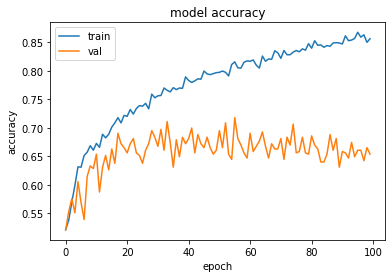

In [25]:
plt.plot(history.history['classifier_acc'])
plt.plot(history.history['val_classifier_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [26]:
#Testing with totally unseen video frame
ae.evaluate(generate_data(testing_batches),steps = np.ceil(testing_batches.samples/64))

1/1 [==============================] - 0s 2ms/step - loss: 0.6455 - decoder_loss: 0.0756 - classifier_loss: 0.5699 - classifier_acc: 0.7500


[0.6455109715461731, 0.0756121426820755, 0.5698988437652588, 0.75]